In [2]:
!uv pip install pandas matplotlib -q

In [4]:
import pandas as pd
df = pd.read_json("./traffic_report.jsonl", lines=True)

In [5]:
df.head()

,query_time,origin,destination,clear_duration_mins,traffic_duration_mins
0,2025-10-04 22:28:23.993181,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.666667
1,2025-10-04 22:30:02.670300,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.833333
2,2025-10-04 22:35:02.525222,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,14.066667
3,2025-10-04 22:40:02.322524,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,14.033333
4,2025-10-04 22:45:02.199550,"164 Devonshire Rd, London SE23 3SZ, UK","70 Thurlow Park Rd, Norwood, London SE21 8HZ, UK",10.7,13.500000


<Axes: xlabel='query_time'>

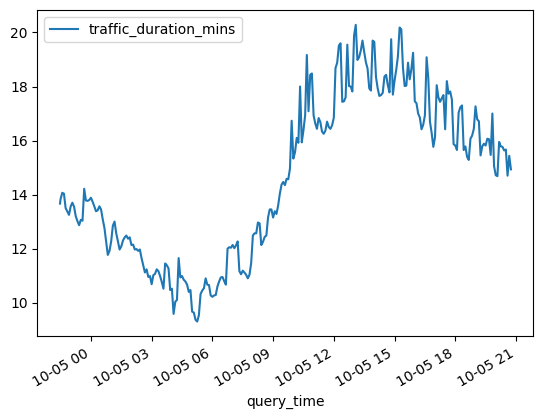

In [6]:
df.plot("query_time", "traffic_duration_mins")

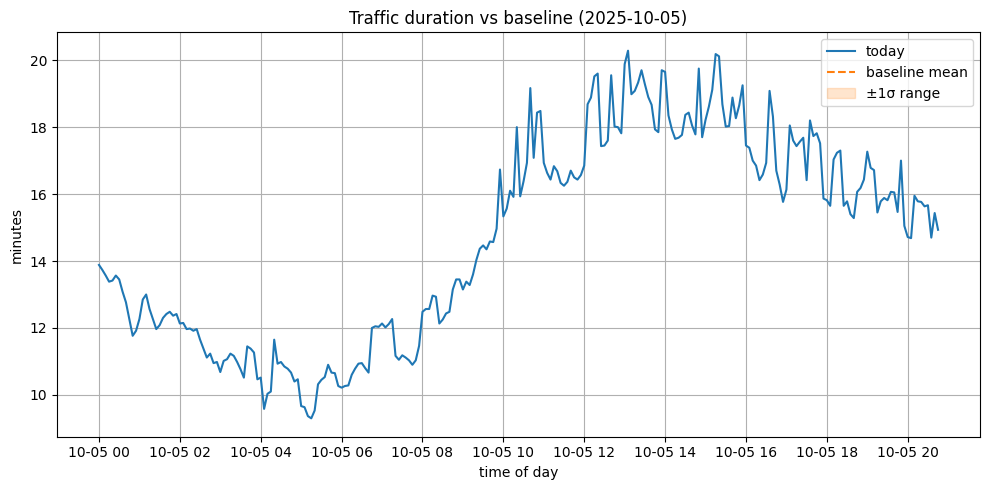

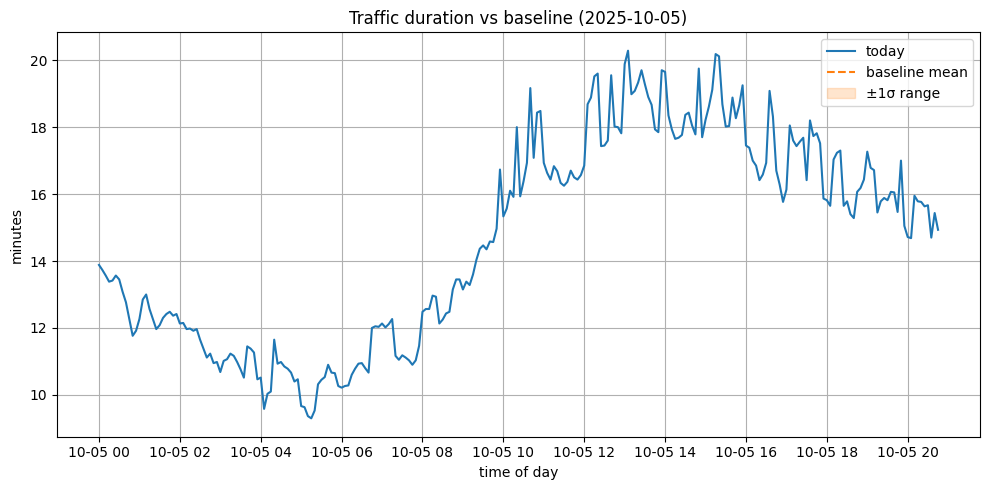

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Parse timestamps and create time features ---
df["query_time"] = pd.to_datetime(df["query_time"])
df["date"] = df["query_time"].dt.date
df["weekday"] = df["query_time"].dt.day_name()
df["time_bucket"] = df["query_time"].dt.floor("5min")  # round to nearest 5 min
df["time_of_day"] = df["time_bucket"].dt.time

# --- 2️⃣ Build baseline from all *past* days ---
today = df["date"].max()
baseline_df = (
    df[df["date"] < today]
    .groupby(["weekday", "time_of_day"])["traffic_duration_mins"]
    .agg(["mean", "std"])
    .reset_index()
)

# --- 3️⃣ Extract today’s data and join with baseline ---
today_df = df[df["date"] == today].copy()
today_df["weekday"] = today_df["query_time"].dt.day_name()
today_df["time_of_day"] = today_df["query_time"].dt.floor("5min").dt.time

merged = today_df.merge(
    baseline_df,
    on=["weekday", "time_of_day"],
    how="left",
    suffixes=("", "_baseline")
)

# --- 4️⃣ Plot today vs baseline ±1σ ---
plt.figure(figsize=(10,5))
plt.plot(merged["query_time"], merged["traffic_duration_mins"], label="today", color="C0")

plt.plot(
    merged["query_time"],
    merged["mean"],
    label="baseline mean",
    color="C1",
    linestyle="--"
)
plt.fill_between(
    merged["query_time"],
    merged["mean"] - merged["std"],
    merged["mean"] + merged["std"],
    color="C1",
    alpha=0.2,
    label="±1σ range"
)

plt.title(f"Traffic duration vs baseline ({today})")
plt.ylabel("minutes")
plt.xlabel("time of day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Parse timestamps and create time features ---
df["query_time"] = pd.to_datetime(df["query_time"])
df["date"] = df["query_time"].dt.date
df["weekday"] = df["query_time"].dt.day_name()
df["time_bucket"] = df["query_time"].dt.floor("5min")  # round to nearest 5 min
df["time_of_day"] = df["time_bucket"].dt.time

# --- 2️⃣ Build baseline from all *past* days ---
today = df["date"].max()
baseline_df = (
    df[df["date"] < today]
    .groupby(["weekday", "time_of_day"])["traffic_duration_mins"]
    .agg(["mean", "std"])
    .reset_index()
)

# --- 3️⃣ Extract today’s data and join with baseline ---
today_df = df[df["date"] == today].copy()
today_df["weekday"] = today_df["query_time"].dt.day_name()
today_df["time_of_day"] = today_df["query_time"].dt.floor("5min").dt.time

merged = today_df.merge(
    baseline_df,
    on=["weekday", "time_of_day"],
    how="left",
    suffixes=("", "_baseline")
)

# --- 4️⃣ Plot today vs baseline ±1σ ---
plt.figure(figsize=(10,5))
plt.plot(merged["query_time"], merged["traffic_duration_mins"], label="today", color="C0")

plt.plot(
    merged["query_time"],
    merged["mean"],
    label="baseline mean",
    color="C1",
    linestyle="--"
)
plt.fill_between(
    merged["query_time"],
    merged["mean"] - merged["std"],
    merged["mean"] + merged["std"],
    color="C1",
    alpha=0.2,
    label="±1σ range"
)

plt.title(f"Traffic duration vs baseline ({today})")
plt.ylabel("minutes")
plt.xlabel("time of day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


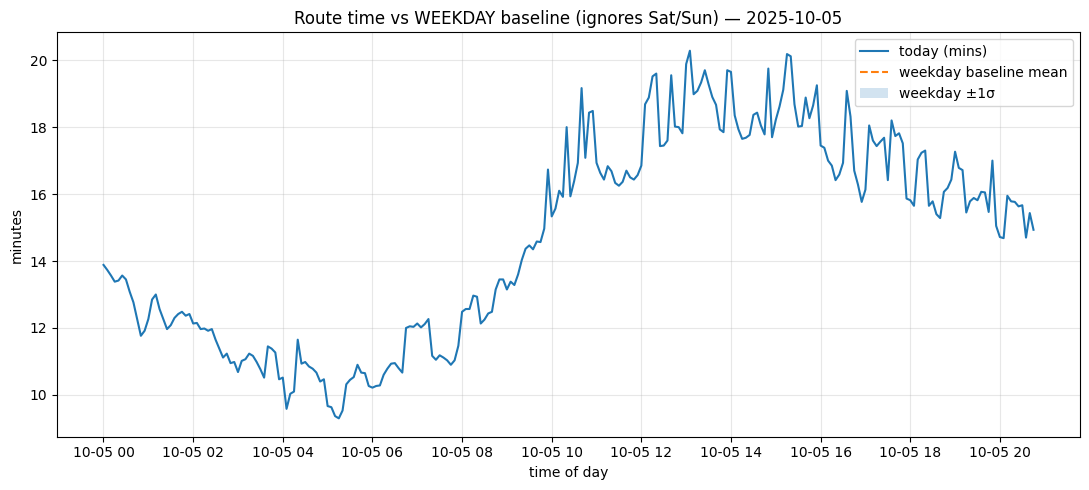

Potential anomalies: 0


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parse & features ---
df["query_time"] = pd.to_datetime(df["query_time"])
df["date"] = df["query_time"].dt.date
df["dow"] = df["query_time"].dt.dayofweek  # 0=Mon ... 6=Sun
df["time_bucket"] = df["query_time"].dt.floor("5min")
df["time_of_day"] = df["time_bucket"].dt.time

today = df["date"].max()

# --- Build WEEKDAY baseline (Mon–Fri), from all past data (optional: exclude today) ---
weekday_mask = df["dow"] < 5
history_mask = df["date"] < today  # keep this to avoid peeking at today
baseline_df = (
    df[weekday_mask & history_mask]
    .groupby("time_of_day")["traffic_duration_mins"]
    .agg(mean="mean", std="std", count="count")
    .reset_index()
)

# If std is NaN (single sample), set to 0
baseline_df["std"] = baseline_df["std"].fillna(0.0)

# --- Today’s series (bucket to 5-min to align) ---
today_df = (
    df[df["date"] == today]
    .assign(time_of_day=lambda x: x["query_time"].dt.floor("5min").dt.time)
    .sort_values("query_time")
    .copy()
)

# --- Merge today with baseline ---
merged = today_df.merge(baseline_df, on="time_of_day", how="left")

# Helpful deviation columns
merged["pct_dev"] = 100 * (merged["traffic_duration_mins"] - merged["mean"]) / merged["mean"]
merged["z"] = (merged["traffic_duration_mins"] - merged["mean"]) / merged["std"].replace(0, np.nan)

# --- Plot: today vs weekday baseline ±1σ ---
plt.figure(figsize=(11, 5))
plt.plot(merged["query_time"], merged["traffic_duration_mins"], label="today (mins)")

# Baseline mean line (aligned to today's timestamps for clean overlay)
plt.plot(merged["query_time"], merged["mean"], linestyle="--", label="weekday baseline mean")

# Shaded ±1σ band (only where baseline exists)
lower = merged["mean"] - merged["std"]
upper = merged["mean"] + merged["std"]
plt.fill_between(merged["query_time"], lower, upper, alpha=0.2, label="weekday ±1σ")

plt.title(f"Route time vs WEEKDAY baseline (ignores Sat/Sun) — {today}")
plt.xlabel("time of day")
plt.ylabel("minutes")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- (Optional) quick anomaly table for your console ---
# Show points > +30% above baseline and z>2 (tweak thresholds as you like)
anoms = merged[(merged["pct_dev"] > 30) & (merged["z"] > 2)]
print(f"Potential anomalies: {len(anoms)}")
if not anoms.empty:
    display(anoms[["query_time","traffic_duration_mins","mean","pct_dev","z"]].head(10))
